In [2]:
# ================== Cell 1: Data Preparation ==================
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
)
from copy import deepcopy
from lightgbm import LGBMClassifier  # Make sure: pip install lightgbm

# =========================================================
# 1. Load preprocessed data (after feature engineering)
# =========================================================
train_path = '../data/processed/train_data_engineered.csv'
test_path  = '../data/processed/test_data_engineered.csv'

train_df = pd.read_csv(train_path, index_col='DateTime', parse_dates=True)
test_df  = pd.read_csv(test_path,  index_col='DateTime', parse_dates=True)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

# =========================================================
# 2. Build the target: future CO(GT) at horizon H
# =========================================================
HORIZON_HOURS = 1   # t+1; for t+6, set 6; etc.

train_df['CO_future'] = train_df['CO(GT)'].shift(-HORIZON_HOURS)
test_df['CO_future']  = test_df['CO(GT)'].shift(-HORIZON_HOURS)

# =========================================================
# 3. Discretize CO_future into 3 classes: low / mid / high
# =========================================================

USE_QUANTILE_BINS = True

def make_labels_by_thresholds(series):
    """
    Use absolute thresholds from the project spec:
      low:  CO < 1.5
      mid:  1.5 <= CO < 2.5
      high: CO >= 2.5
    """
    bins = [-np.inf, 1.5, 2.5, np.inf]
    labels = ['low', 'mid', 'high']
    return pd.cut(series, bins=bins, labels=labels)

def make_labels_by_quantiles(series):
    """
    Use 1/3 and 2/3 quantiles as cut points for low / mid / high.
    """
    q1, q2 = series.quantile([1/3, 2/3])
    bins = [-np.inf, q1, q2, np.inf]
    labels = ['low', 'mid', 'high']
    return pd.cut(series, bins=bins, labels=labels)

if USE_QUANTILE_BINS:
    train_df['CO_future_class'] = make_labels_by_quantiles(train_df['CO_future'])
    test_df['CO_future_class']  = make_labels_by_quantiles(test_df['CO_future'])
else:
    train_df['CO_future_class'] = make_labels_by_thresholds(train_df['CO_future'])
    test_df['CO_future_class']  = make_labels_by_thresholds(test_df['CO_future'])

# Drop rows where label is NaN (mostly the tail after shifting)
train_df = train_df.dropna(subset=['CO_future_class'])
test_df  = test_df.dropna(subset=['CO_future_class'])

print("\nAfter building labels:")
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("Train label counts:\n", train_df['CO_future_class'].value_counts())
print("Test label counts:\n",  test_df['CO_future_class'].value_counts())

# =========================================================
# 4. Prepare feature matrix X and target y
# =========================================================
TARGET_COL = 'CO_future_class'
DROP_COLS = ['CO_future', 'CO_future_class']  # not used as input features

feature_cols = [c for c in train_df.columns if c not in DROP_COLS]

X_train = train_df[feature_cols].values
y_train = train_df[TARGET_COL].values

X_test  = test_df[feature_cols].values
y_test  = test_df[TARGET_COL].values

print("\nNumber of features used:", len(feature_cols))

# =========================================================
# 5. For MLP: time-aware train/val split + scaling
# =========================================================
train_sorted = train_df.sort_index()

# Split: first 80% as train_core, last 20% as val (time-aware)
n_total = len(train_sorted)
val_frac = 0.2
n_val = int(n_total * val_frac)

val_df = train_sorted.iloc[-n_val:]
train_core_df = train_sorted.iloc[:-n_val]

X_train_core = train_core_df[feature_cols].values
y_train_core = train_core_df[TARGET_COL].values

X_val = val_df[feature_cols].values
y_val = val_df[TARGET_COL].values

# Test set (raw)
X_test_raw = X_test
y_test_raw = y_test

# Standardization: fit on train_core, then apply to val/test
scaler = StandardScaler()
X_train_core_scaled = scaler.fit_transform(X_train_core)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_raw)

# Label order used later for confusion matrices & macro metrics
labels_order = ['low', 'mid', 'high']


Train shape: (7110, 129)
Test shape : (2247, 129)

After building labels:
Train shape: (7109, 131)
Test shape : (2246, 131)
Train label counts:
 CO_future_class
low     2458
mid     2395
high    2256
Name: count, dtype: int64
Test label counts:
 CO_future_class
low     780
mid     748
high    718
Name: count, dtype: int64

Number of features used: 129


Epoch 001 | train_loss = 0.9395 | valid_loss = 0.7742 | val_acc = 0.6601
Epoch 002 | train_loss = 0.6461 | valid_loss = 0.6775 | val_acc = 0.7277
Epoch 003 | train_loss = 0.5591 | valid_loss = 0.6974 | val_acc = 0.7185
Epoch 004 | train_loss = 0.5117 | valid_loss = 0.6401 | val_acc = 0.7361
Epoch 005 | train_loss = 0.4797 | valid_loss = 0.6509 | val_acc = 0.7410
Epoch 006 | train_loss = 0.4579 | valid_loss = 0.6380 | val_acc = 0.7509
Epoch 007 | train_loss = 0.4409 | valid_loss = 0.5947 | val_acc = 0.7621
Epoch 008 | train_loss = 0.4271 | valid_loss = 0.6045 | val_acc = 0.7544
Epoch 009 | train_loss = 0.4174 | valid_loss = 0.5840 | val_acc = 0.7643
Epoch 010 | train_loss = 0.4060 | valid_loss = 0.6211 | val_acc = 0.7572
Epoch 011 | train_loss = 0.3987 | valid_loss = 0.5991 | val_acc = 0.7607
Epoch 012 | train_loss = 0.3928 | valid_loss = 0.6095 | val_acc = 0.7600
Epoch 013 | train_loss = 0.3846 | valid_loss = 0.5711 | val_acc = 0.7748
Epoch 014 | train_loss = 0.3772 | valid_loss = 0.56

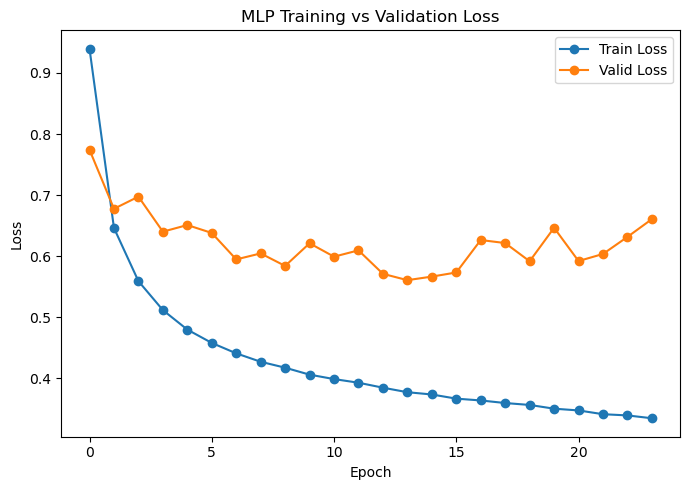

In [10]:
# ================== Cell 2: MLP Training (L2 + Time-aware Early Stopping)
#   + Train Loss + Valid Loss Curve ==================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
from copy import deepcopy

# 假设以下变量都来自 Cell 1：
# X_train_core_scaled, y_train_core, X_val_scaled, y_val, X_test_scaled, y_test_raw


# ----- MLP Model -----
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    alpha=0.006,
    max_iter=1,
    warm_start=True,
    random_state=42
)

classes = np.unique(y_train_core)

max_epochs = 100
n_iter_no_change = 10
best_val_acc = -np.inf
best_model = None
epochs_no_improve = 0

# ----- 记录 loss & acc -----
train_losses = []
valid_losses = []
val_acc_list = []

# y_val 是字符串（low/mid/high），需要转成编码
class_to_idx = {c: i for i, c in enumerate(classes)}
y_val_numeric = np.array([class_to_idx[c] for c in y_val])

for epoch in range(max_epochs):

    # Shuffle training order
    idx = np.arange(len(X_train_core_scaled))
    np.random.shuffle(idx)
    X_epoch = X_train_core_scaled[idx]
    y_epoch = y_train_core[idx]

    # First partial_fit needs "classes"
    if epoch == 0:
        mlp.partial_fit(X_epoch, y_epoch, classes=classes)
    else:
        mlp.partial_fit(X_epoch, y_epoch)

    # ----- Train Loss -----
    train_losses.append(mlp.loss_)

    # ----- Valid Loss -----
    y_val_proba = mlp.predict_proba(X_val_scaled)
    valid_loss = log_loss(y_val_numeric, y_val_proba)
    valid_losses.append(valid_loss)

    # ----- Valid Accuracy -----
    y_val_pred = mlp.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1:03d} | "
          f"train_loss = {mlp.loss_:.4f} | "
          f"valid_loss = {valid_loss:.4f} | "
          f"val_acc = {val_acc:.4f}")

    # ----- Early stopping -----
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        best_model = deepcopy(mlp)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= n_iter_no_change:
        print(f"\nEarly stopping at epoch {epoch+1}, best val_acc = {best_val_acc:.4f}")
        break

# 恢复最佳模型
if best_model is not None:
    mlp = best_model


# ================== Test Evaluation ==================
y_pred_mlp = mlp.predict(X_test_scaled)

print("\n" + "="*60)
print("Neural Network (MLP) Results with Full Loss Curves")
print("="*60)
print("Accuracy:", accuracy_score(y_test_raw, y_pred_mlp))
print("\nClassification report:\n", classification_report(y_test_raw, y_pred_mlp))


# ================== Plot: Train vs Valid Loss ==================
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(valid_losses, label="Valid Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# ================== Cell 3: Logistic Regression + LightGBM + Naive Baseline ==================

# -------- Logistic Regression (Baseline) --------
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features to similar ranges
    ('clf', LogisticRegression(
        multi_class='multinomial',
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ))
])

log_reg_pipeline.fit(X_train, y_train)
y_pred_log = log_reg_pipeline.predict(X_test)

print("\n" + "="*60)
print("Logistic Regression (Baseline) Results")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification report:\n", classification_report(y_test, y_pred_log))

# -------- LightGBM --------
lgbm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier(
        objective='multiclass',
        num_class=3,            # low / mid / high
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42,
        n_jobs=-1,
        num_leaves=63,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        min_split_gain=0.01,
        reg_lambda=1.0
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred_lgbm = lgbm_pipeline.predict(X_test)

print("\n" + "="*60)
print("LightGBM Results")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification report:\n", classification_report(y_test, y_pred_lgbm))

# -------- Naive Baseline: CO(t) class as prediction for CO(t+H) --------
print("\n" + "="*60)
print("Naive Baseline (Use CO(t) class to predict CO(t+H))")
print("="*60)

# 先对当前 CO(GT) 做分类（与目标保持一致）
if USE_QUANTILE_BINS:
    train_df['CO_current_class'] = make_labels_by_quantiles(train_df['CO(GT)'])
    test_df['CO_current_class']  = make_labels_by_quantiles(test_df['CO(GT)'])
else:
    train_df['CO_current_class'] = make_labels_by_thresholds(train_df['CO(GT)'])
    test_df['CO_current_class']  = make_labels_by_thresholds(test_df['CO(GT)'])

# Naive prediction: y_pred = 当前时刻的 CO 分类
y_pred_naive = test_df['CO_current_class'].values

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_naive))
print("\nClassification report:\n", classification_report(y_test, y_pred_naive))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_naive))


d:\Anaconda\envs\AI\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (Baseline) Results
Accuracy: 0.7666963490650045

Classification report:
               precision    recall  f1-score   support

        high       0.86      0.74      0.80       718
         low       0.83      0.83      0.83       780
         mid       0.64      0.73      0.68       748

    accuracy                           0.77      2246
   macro avg       0.78      0.77      0.77      2246
weighted avg       0.78      0.77      0.77      2246

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28258
[LightGBM] [Info] Number of data points in the train set: 7109, number of used features: 129
[LightGBM] [Info] Start training from score -1.147768
[LightGBM] [Info] Start training from score -1.062014
[LightGBM] [Info] Start training from score -1.087978
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

d:\Anaconda\envs\AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


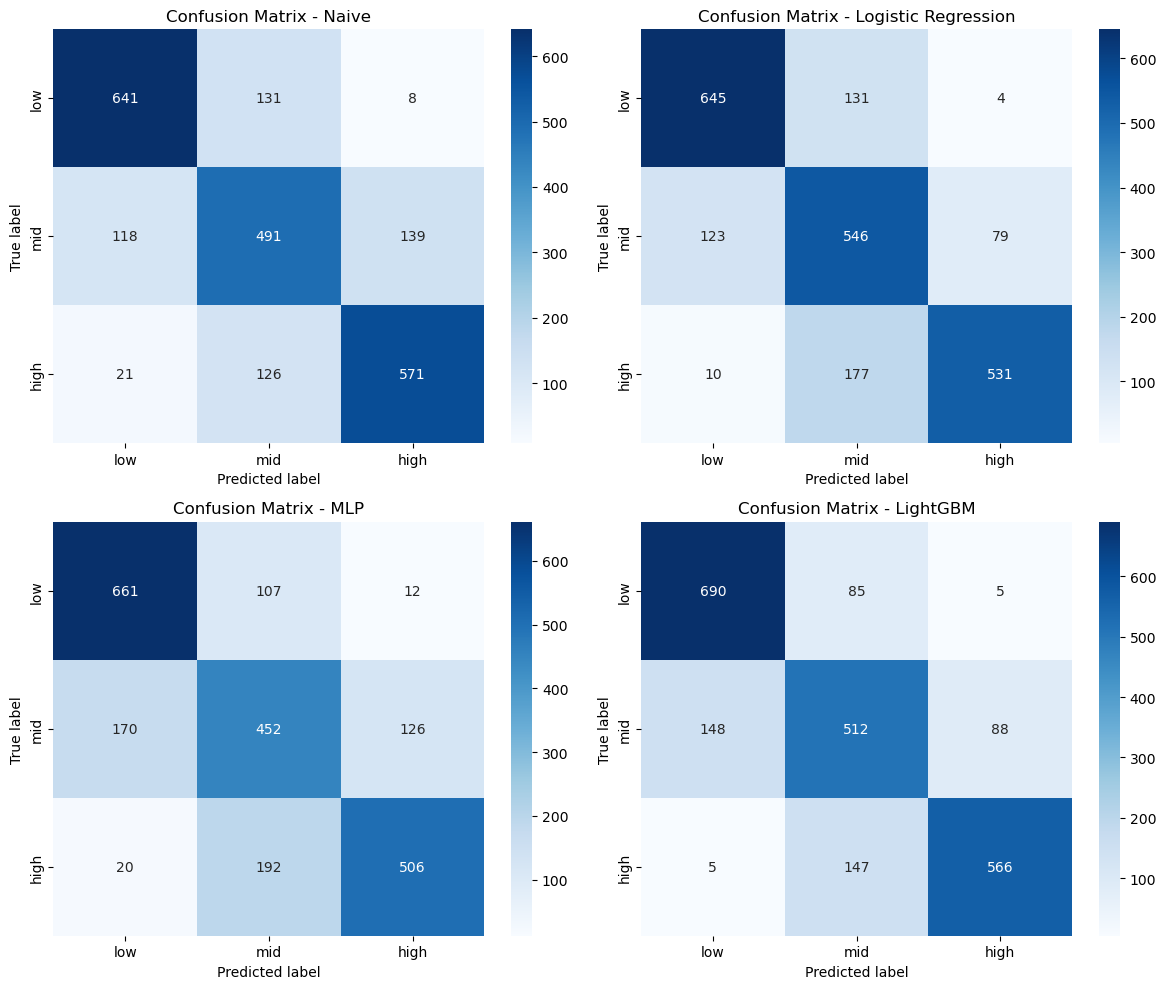


Model Comparison Summary
Naive                | Accuracy: 0.7582 | Macro-F1: 0.7578 | Macro-Precision: 0.7578 | Macro-Recall: 0.7578 | Balanced Acc: 0.7578
Logistic Regression  | Accuracy: 0.7667 | Macro-F1: 0.7690 | Macro-Precision: 0.7777 | Macro-Recall: 0.7655 | Balanced Acc: 0.7655
MLP                  | Accuracy: 0.7208 | Macro-F1: 0.7189 | Macro-Precision: 0.7214 | Macro-Recall: 0.7188 | Balanced Acc: 0.7188
LightGBM             | Accuracy: 0.7872 | Macro-F1: 0.7862 | Macro-Precision: 0.7885 | Macro-Recall: 0.7858 | Balanced Acc: 0.7858


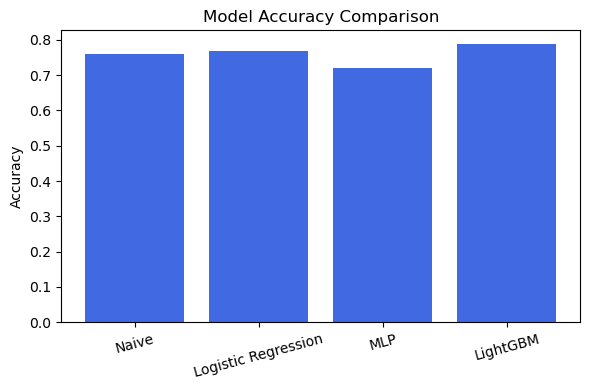

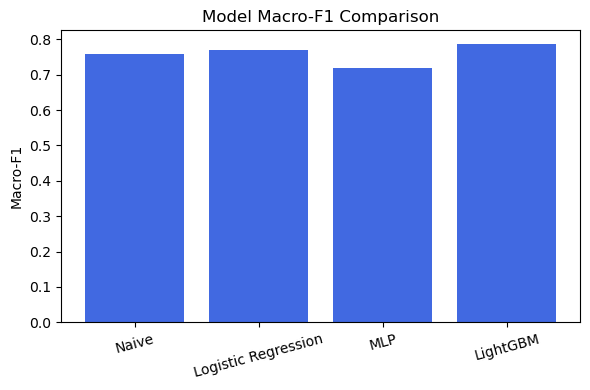

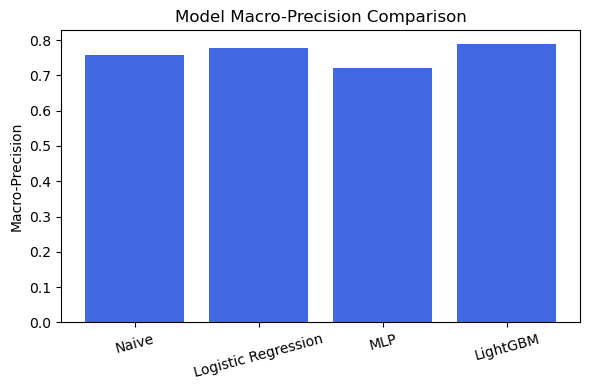

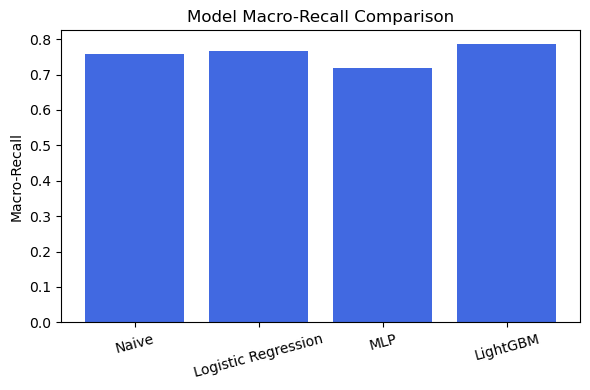

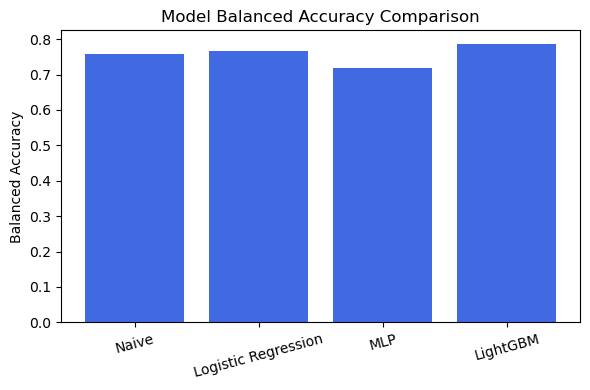

In [5]:
# ================== Cell 4: Final Evaluation & Plots ==================
import matplotlib.pyplot as plt
import seaborn as sns

pred_dict = {
    "Naive": y_pred_naive,
    "Logistic Regression": y_pred_log,
    "MLP": y_pred_mlp,
    "LightGBM": y_pred_lgbm,
}

# ---- 1) Confusion matrices (blue colormap) ----
plt.figure(figsize=(12, 10))

for i, (name, y_pred) in enumerate(pred_dict.items(), start=1):
    cm = confusion_matrix(y_test, y_pred, labels=labels_order)

    plt.subplot(2, 2, i)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=labels_order,
        yticklabels=labels_order,
        cmap="Blues"
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix - {name}")

plt.tight_layout()
plt.show()

# ---- 2) Metrics summary (Accuracy, Macro-F1, Macro-Precision, Macro-Recall, Balanced Accuracy) ----
model_names = []
accuracies = []
macro_f1s = []
macro_precisions = []
macro_recalls = []
balanced_accuracies = []

for name, y_pred in pred_dict.items():
    model_names.append(name)
    accuracies.append(accuracy_score(y_test, y_pred))
    macro_f1s.append(f1_score(y_test, y_pred, labels=labels_order, average='macro'))
    macro_precisions.append(precision_score(y_test, y_pred, labels=labels_order, average='macro', zero_division=0))
    macro_recalls.append(recall_score(y_test, y_pred, labels=labels_order, average='macro', zero_division=0))
    balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))

print("\n" + "="*60)
print("Model Comparison Summary")
print("="*60)
for name, acc, f1_m, prec_m, rec_m, bal_acc in zip(
    model_names, accuracies, macro_f1s, macro_precisions, macro_recalls, balanced_accuracies
):
    print(f"{name:20s} | "
          f"Accuracy: {acc:.4f} | "
          f"Macro-F1: {f1_m:.4f} | "
          f"Macro-Precision: {prec_m:.4f} | "
          f"Macro-Recall: {rec_m:.4f} | "
          f"Balanced Acc: {bal_acc:.4f}")

# ---- 3) Bar charts ----

# (a) Accuracy
plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies, color="royalblue")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# (b) Macro-F1
plt.figure(figsize=(6, 4))
plt.bar(model_names, macro_f1s, color="royalblue")
plt.ylabel("Macro-F1")
plt.title("Model Macro-F1 Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# (c) Macro-Precision
plt.figure(figsize=(6, 4))
plt.bar(model_names, macro_precisions, color="royalblue")
plt.ylabel("Macro-Precision")
plt.title("Model Macro-Precision Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# (d) Macro-Recall
plt.figure(figsize=(6, 4))
plt.bar(model_names, macro_recalls, color="royalblue")
plt.ylabel("Macro-Recall")
plt.title("Model Macro-Recall Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# (e) Balanced Accuracy
plt.figure(figsize=(6, 4))
plt.bar(model_names, balanced_accuracies, color="royalblue")
plt.ylabel("Balanced Accuracy")
plt.title("Model Balanced Accuracy Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
